In [7]:
# Ensure repository root (with 'src/') is on sys.path\nimport sys\nfrom pathlib import Path\n# Try: notebook dir, project root, and parent\ncands = [Path.cwd(), Path.cwd() / '..', Path.cwd() / '../..']\nfor p in [Path(c).resolve() for c in cands]:\n    if p.exists() and (p/'src').exists():\n        sp = str(p)\n        if sp not in sys.path:\n            sys.path.insert(0, sp)\n        break\n
import sys; sys.path.insert(0, r'C:\Users\pertt\Alleyfoo\Data-enrichment\karaoke-genre-enrichment')

# Karaoke Genre Enrichment Project Overview

This notebook provides a single, shareable overview of the project: goals, data flow, setup, how to run demos, and how the enrichment + validation pieces can be orchestrated on cloud. It includes small executable snippets that run without secrets (seed creation, mock validation visual), with pointers to CLI flows that require credentials.

## Executive Summary

- Purpose: enrich a karaoke song catalog with Discogs metadata (genre/style/year/label/URL) and flag potential issues using a mock or hosted small-LLM validator.
- Inputs/Outputs: reads an Excel workbook (`data/karaoke_songs.xlsx`), writes reports to Excel (`data/karaoke_songs_enriched.xlsx`, `data/karaoke_songs_cleaned.xlsx`).
- No-secrets demo: the mock validator and cleaner run locally without API keys.
- With secrets: Discogs enrichment requires `DISCOGS_TOKEN`. Optional hosted LLM validation/cleaning uses `LLM_*` variables.
- Cloud: the same steps can be scheduled and validated inside AWS (Glue/Lambda) and Azure (Data Factory/Synapse) as part of a pipeline.

## Repository Map

- CLI scripts (Python modules):
  - `src/seed_data.py` creates the seed Excel workbook.
  - `src/llm_clean.py` mock or hosted-LLM cleaner for fields (no Discogs required).
  - `src/enrich_genres.py` Discogs enrichment (requires token).
- Core utilities: `src/utils.py`, `src/genre_validators.py`, `src/validators.py`, `src/discogs_client.py`.
- Data: `data/` holds input/output Excel and `data/cache/` for Discogs API responses.
- Notebooks: this overview, plus `01_genre_enrichment_demo.ipynb` (CLI-driven flow) and `02_cloud_llm_showcase.ipynb` (bilingual mock validator demo).
- Docs: `README.md`, `docs/llm-integration.md`, slides in `docs/slides/`.

## Data Model (Excel `songs` sheet)

Columns used across the flows (seeded by `src/seed_data.py`):
- song_title, artist, language, genre, style, year, label
- discogs_url, discogs_genres, discogs_styles, discogs_year, discogs_label
- status, notes
- llm_verdict, llm_confidence, flagged_for_review, validation_status

Discogs columns store what the API reports; existing DB values are compared without being overwritten unless you explicitly choose to fill blanks.

## Setup

- Create venv and install dependencies:
  ```bash
  python -m venv .venv
  source .venv/bin/activate   # Windows: .venv\Scripts\activate
  pip install -r requirements.txt
  ```
- Optional secrets: copy `.env.example` to `.env` and set:
  - `DISCOGS_TOKEN` (required for Discogs enrichment)
  - `LLM_API_BASE`, `LLM_MODEL`, `LLM_API_KEY` (optional; for hosted cleaner/validator)
- The mock flows run without any keys.

In [4]:
# Quick environment + import check (adds repo root with 'src/' to sys.path)\nfrom pathlib import Path\nimport os, sys, importlib\nprint('CWD:', Path.cwd())\n# Ensure a directory containing 'src' is on sys.path\nrepo_root = None\nfor p in [Path.cwd()] + list(Path.cwd().parents):\n    if (p / 'src').exists():\n        repo_root = p.resolve()\n        if str(repo_root) not in sys.path:\n            sys.path.insert(0, str(repo_root))\n        break\nprint('Repo root detected:' , repo_root)\n# Test import of project modules\ntry:\n    import src\n    from src.seed_data import ensure_seed_workbook, SONGS_SHEET_NAME\n    print('OK   src + src.seed_data import')\nexcept Exception as exc:\n    print('WARN src import failed:', exc)\n# Basic package checks\nprint(f'Python: {sys.version.split()[0]}')\nfor pkg in ['pandas','openpyxl','matplotlib']:\n    try:\n        importlib.import_module(pkg)\n        print(f'OK   {pkg}')\n    except Exception as exc:\n        print(f'WARN {pkg}: {exc}')\nprint('DISCOGS_TOKEN set? ', bool(os.getenv('DISCOGS_TOKEN')))\nprint('LLM_MODEL set?    ', bool(os.getenv('LLM_MODEL')))\n

## Seed Workbook and Preview

This cell creates the seed workbook if missing and previews the first rows.

In [8]:
from pathlib import Path
import pandas as pd
from src.seed_data import ensure_seed_workbook, SONGS_SHEET_NAME

seed = Path('data/karaoke_songs.xlsx')
ensure_seed_workbook(seed)
df = pd.read_excel(seed, sheet_name=SONGS_SHEET_NAME)
df.head()


,song_title,artist,language,genre,style,year,label,discogs_url,discogs_genres,discogs_styles,discogs_year,discogs_label,status,notes,llm_verdict,llm_confidence,flagged_for_review,validation_status
0,I Want It That Way,Backstreet Boys,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
1,Dancing Queen,ABBA,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
2,Shallow,Lady Gaga & Bradley Cooper,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
3,Bohemian Rhapsody,Queen,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
4,Wonderwall,Oasis,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN


## Discogs Enrichment (Credentials Required)

Discogs enrichment compares your catalog with the API and stores Discogs values in `discogs_*` columns. It can either verify existing rows (match/mismatch) or fill in blanks.

CLI (requires `.env` with `DISCOGS_TOKEN`):

```bash
python -m src.enrich_genres --mode verify                       # compare only
python -m src.enrich_genres --mode fill-missing                 # fill missing metadata (default)
python -m src.enrich_genres --validate --validator mock         # add mock validator verdicts
python -m src.enrich_genres --validate --validator llm          # use hosted small-LLM endpoint
```

Notes:
- Requests are throttled and cached under `data/cache/`.
- You can override input/output paths with `--input`/`--output`.
- For a demo without secrets, skip this and use the mock sections below.

## Cleaning and Validation (Mock or Hosted)

Two complementary flows:
- Cleaning (`src.llm_clean`) suggests normalized fields (artist/title/label/year) Ãƒ¢Ã¢â€š¬Ã¢â,¬ mock or hosted.
- Validation (`src.validators.MockLLMGenreValidator` / `LLMGenreValidator`) flags suspect genres and adds an explainable verdict.

CLI (cleaner):

```bash
python -m src.llm_clean --provider mock --overwrite --limit 10
# or, if you have a compatible endpoint configured
python -m src.llm_clean --provider llm --overwrite --limit 10
```

Notebook demo below uses the mock validator for a quick, reproducible preview.

## LLM Workflow

- Configure environment: `LLM_API_BASE` (OpenAI-compatible), `LLM_MODEL`, optional `LLM_API_KEY`.
- Two entry points:
  - Cleaning: `python -m src.llm_clean --provider llm --overwrite --limit 10`
  - Validation: use `src.validators.LLMGenreValidator` to score plausibility of genre/style.
- If variables are not set, use the mock modes to keep the demo offline.

In [ ]:
# LLM validator demo (runs only if LLM env is configured)
import os
if not os.getenv('LLM_MODEL'):
    print('LLM_MODEL not set; skipping live validator call. Set LLM_API_BASE/LLM_MODEL/LLM_API_KEY to enable.')
else:
    from src.validators import LLMGenreValidator
    validator = LLMGenreValidator()
    sample = {'song_title': 'Bohemian Rhapsody', 'artist': 'Queen', 'language': 'en', 'genre': 'Rock', 'style': 'Opera Rock'}
    try:
        out = validator.evaluate(sample)
        print('LLM verdict:', out)
    except Exception as exc:
        print('[WARN] LLM call failed:', exc)


In [9]:
# Small in-memory demo with the mock validator (no secrets)
import pandas as pd
from src.validators import MockLLMGenreValidator

demo_rows = [
    {"song_title": "Bohemian Rhapsody", "artist": "Queen", "language": "en", "genre": "Country", "style": "Cou-try ballad"},
    {"song_title": "Bohemian Rhapsody", "artist": "Queen", "language": "en", "genre": "Rock / Classic Rock", "style": "Opera Rock"},
    {"song_title": "Satumaa", "artist": "Reijo Taipale", "language": "fi", "genre": "Tango", "style": "Finnish Tango"},
    {"song_title": "Vesivehmaan Jenkka", "artist": "Veikko Tuomi", "language": "fi", "genre": "Cou-try", "style": "Folk"},
]
demo_df = pd.DataFrame(demo_rows)
validator = MockLLMGenreValidator()
verdicts = demo_df.apply(validator.evaluate, axis=1, result_type="expand")
demo_df = pd.concat([demo_df, verdicts], axis=1)
demo_df


,song_title,artist,language,genre,style,llm_verdict,llm_confidence,flagged_for_review
0,Bohemian Rhapsody,Queen,en,Country,Cou-try ballad,Mock LLM: Please review. Unexpected genre toke...,0.92,True
1,Bohemian Rhapsody,Queen,en,Rock / Classic Rock,Opera Rock,Mock LLM: Classification looks consistent.,0.68,False
2,Satumaa,Reijo Taipale,fi,Tango,Finnish Tango,Mock-LLM: Luokitus vaikuttaa sopivalta.,0.68,False
3,Vesivehmaan Jenkka,Veikko Tuomi,fi,Cou-try,Folk,Mock-LLM: Tarkista tiedot. Poikkeava genre 'co...,0.92,True


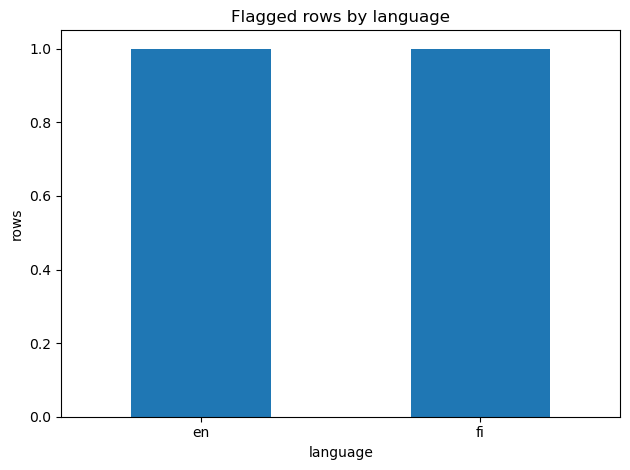

In [10]:
# Quick summary: how many rows need attention per language?
import matplotlib.pyplot as plt
summary = demo_df.groupby('language')['flagged_for_review'].sum().rename('needs_review')
ax = summary.plot.bar(rot=0, title='Flagged rows by language')
ax.set_xlabel('language'); ax.set_ylabel('rows')
plt.tight_layout()
plt.show()


## Cloud Orchestration (AWS / Azure)

- AWS Glue / Lambda: schedule Discogs enrichment as an ETL, land Excel/Parquet on S3, and trigger validation; surface flags in a lightweight dashboard.
- Azure Data Factory / Synapse: mirror the flow in Azure landing zones; publish curated tables to a lakehouse.
- Shared validator: use the mock locally, and swap to a hosted small-LLM endpoint (Azure OpenAI or Bedrock) when credentials are ready.
- CI/CD: parameterize input/output locations and secrets via environment variables or Key Vault/Secrets Manager.

## Runbook Cheatsheet

- Seed workbook: `python -m src.seed_data`
- Mock cleaner: `python -m src.llm_clean --provider mock --overwrite --limit 10`
- Hosted cleaner: set `LLM_*`, then `python -m src.llm_clean --provider llm --overwrite --limit 10`
- Discogs verify/fill: set `DISCOGS_TOKEN`, then `python -m src.enrich_genres [--mode verify|fill-missing]`
- Cache: delete files in `data/cache/` or run with `--overwrite-cache` to refetch Discogs responses.
- Notebooks to share: this overview; `02_cloud_llm_showcase.ipynb` for a bilingual validator demo.

In [ ]:
## Show & Tell: End-to-End Flow

A simple view of how data moves through the project:

AWS/Azure scheduler -> Excel source -> Enrich & Validate -> Transform -> Publish -> Endpoint

```
    [Scheduler (AWS EventBridge / Azure Data Factory)]
             |
             v
    [Compute (AWS Glue/Lambda or Azure Synapse/Function)]
             |
             v
    [Excel Source/Seed]
             |
             v
    [Enrich (Discogs) + Clean/Validate (Mock or LLM endpoint)]
             |
             v
    [Transform (pipe-transformation patterns, CSV/Parquet)]
             |
             v
    [Publish (S3/Blob storage, curated tables)]
             |
             v
    [Endpoint (Dashboard/API)]
    ```